100%|██████████| 300/300 [00:43<00:00, 6.96frame/s] 


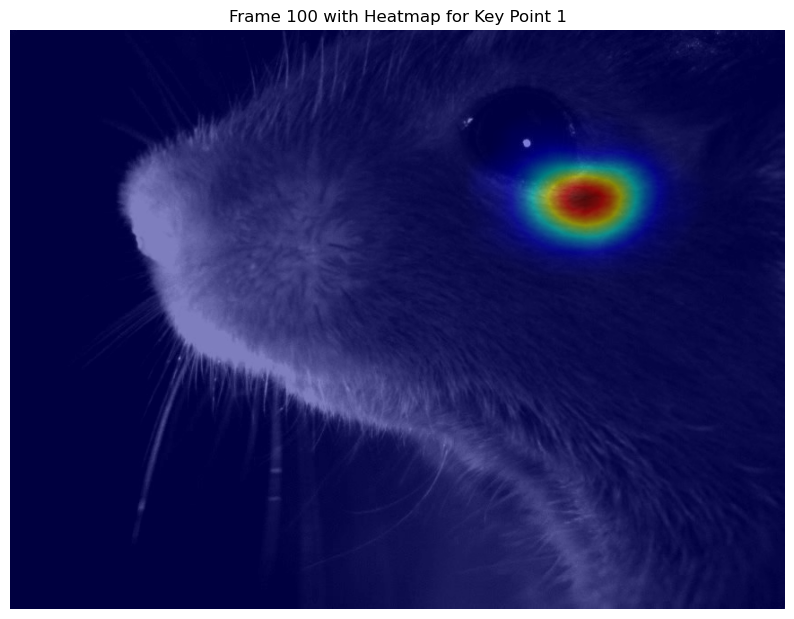

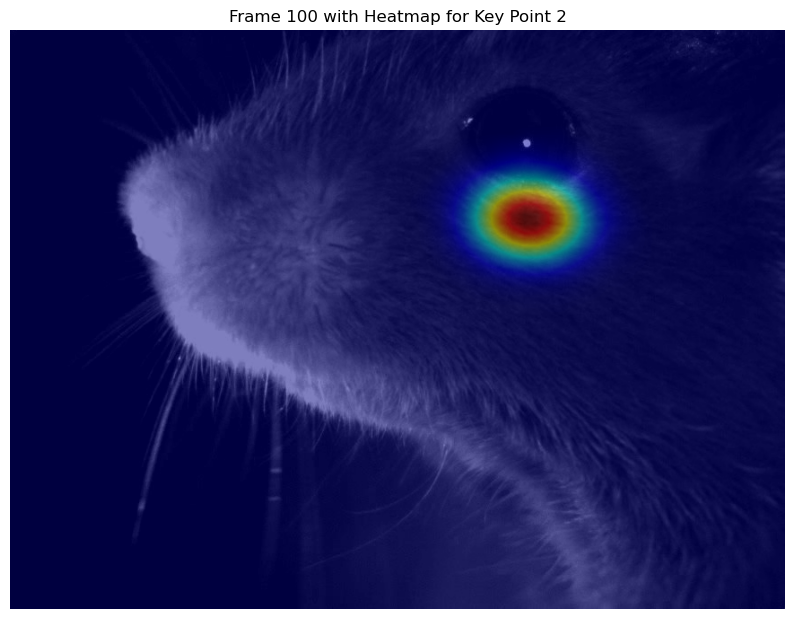

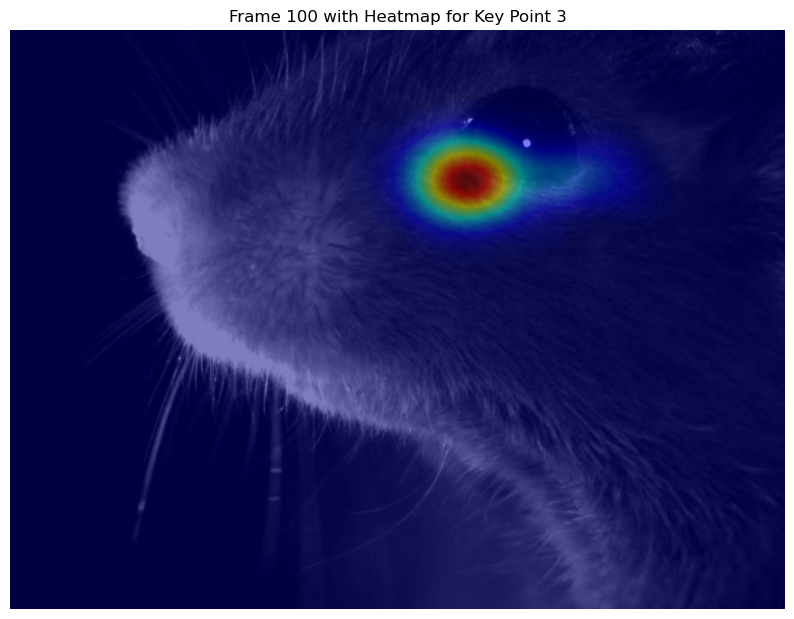

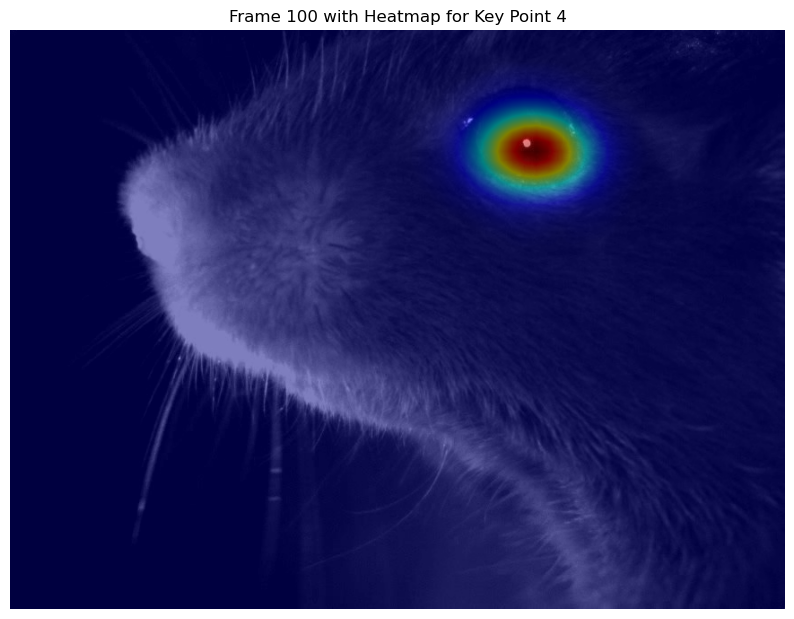

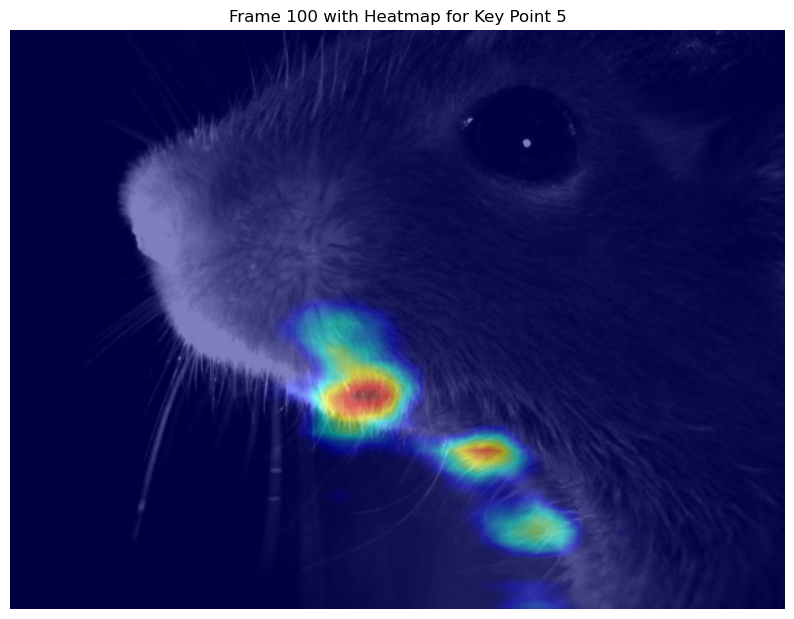

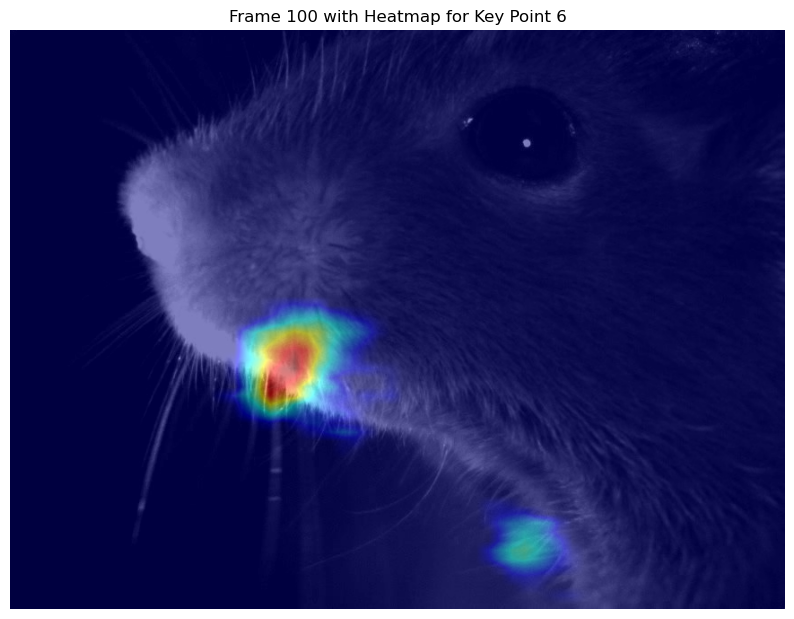

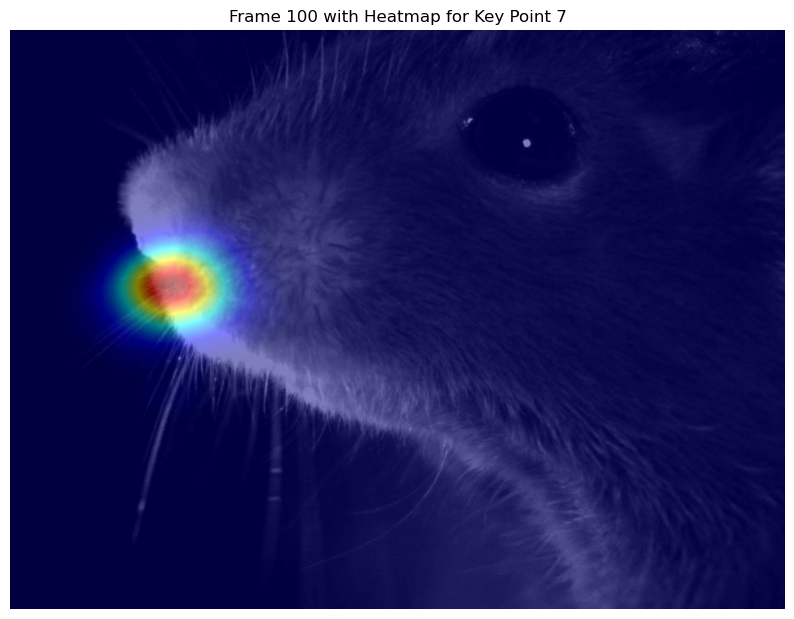

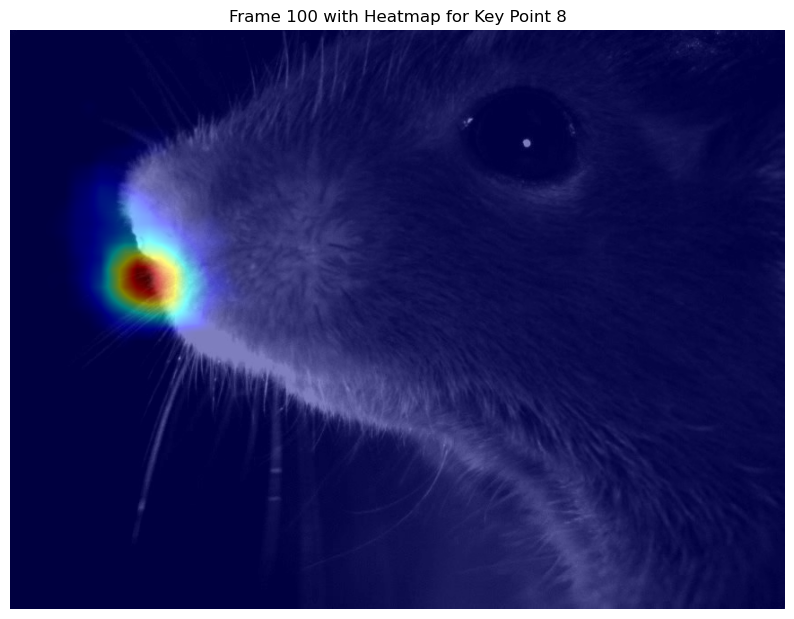

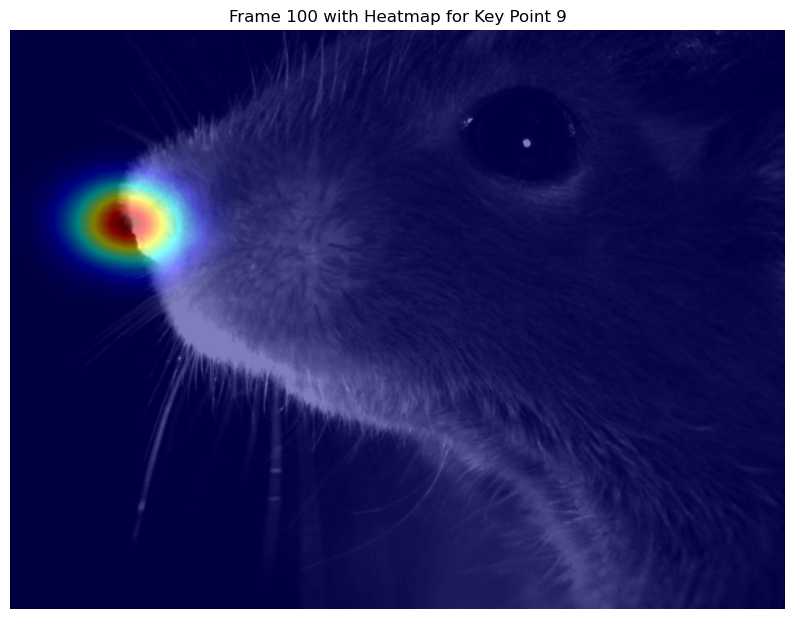

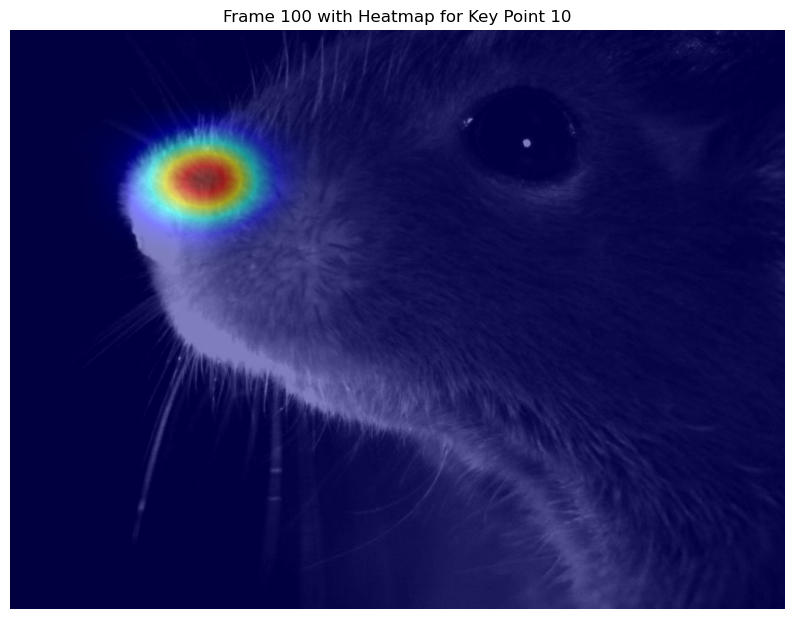

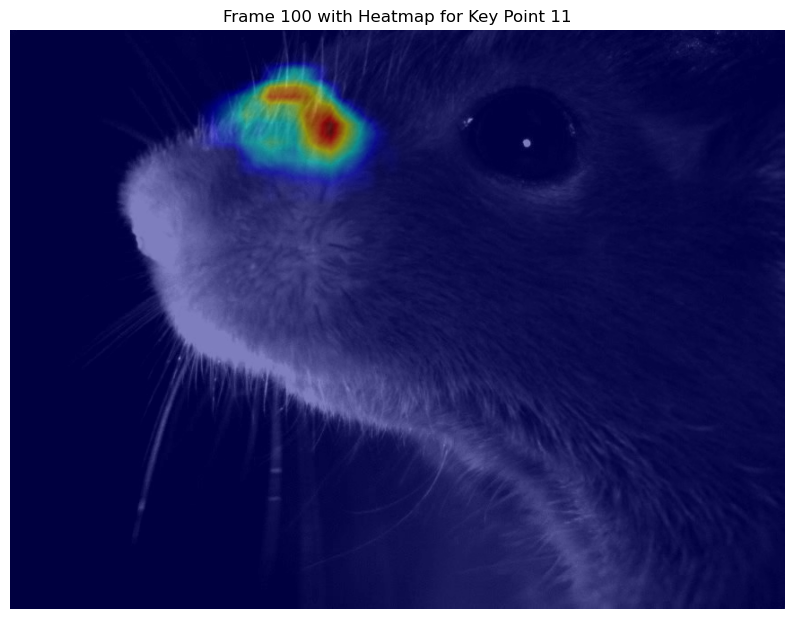

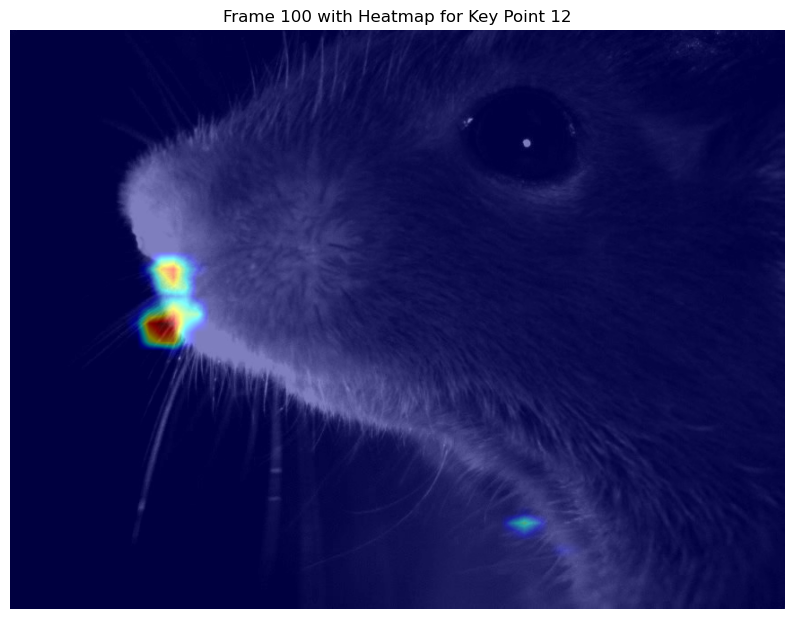

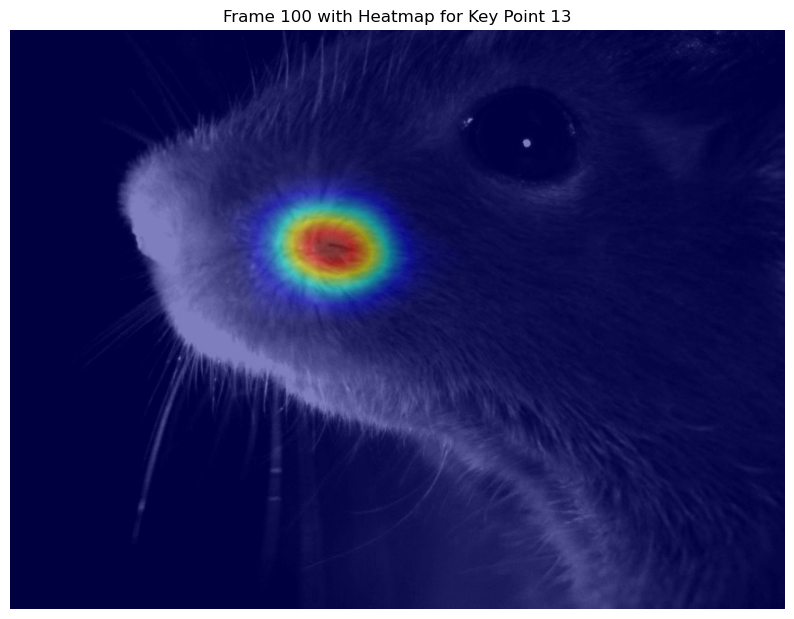

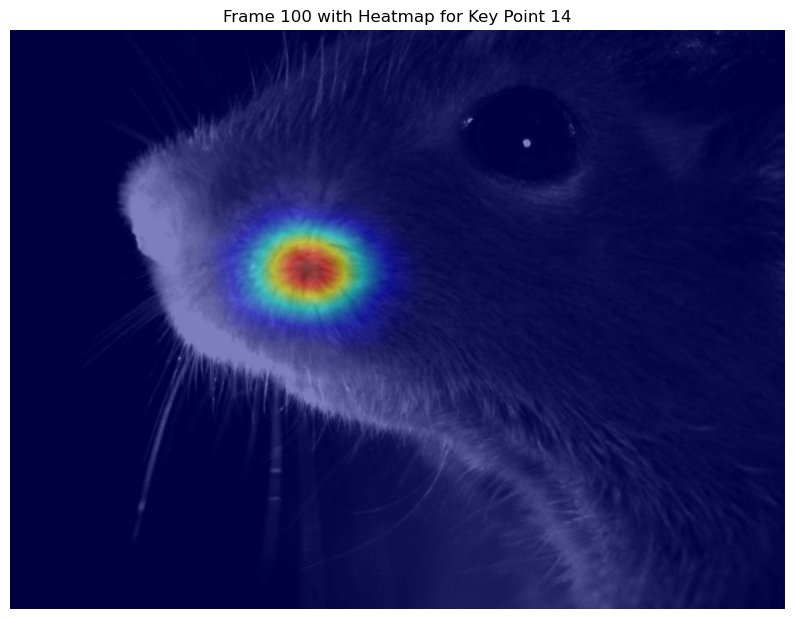

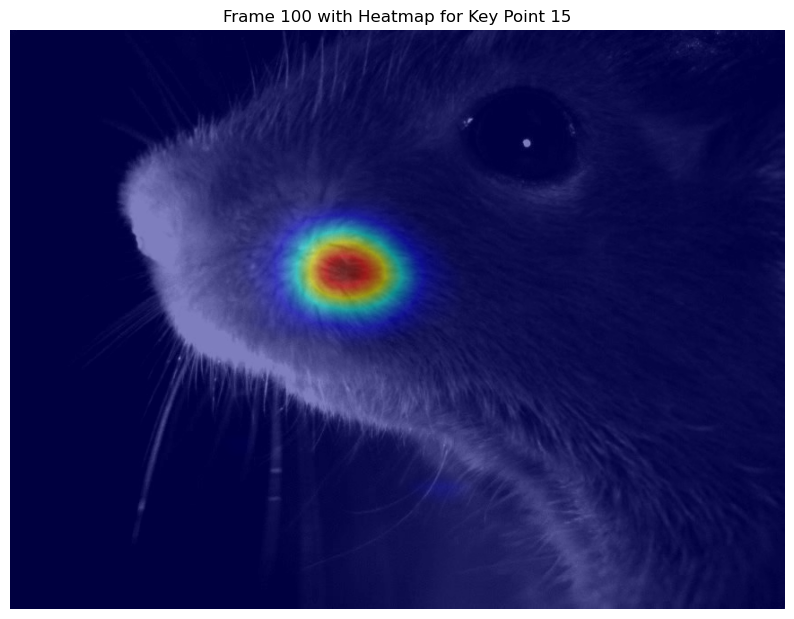

In [ ]:
#VISUALIZE KPs

import matplotlib.pyplot as plt
import cv2
import numpy as np
from facemap.pose.pose import Pose  # Adjust the import path as needed

def visualize_keypoints_heatmaps(video_path, video_id, frame_index, pose_instance):
    """
    Visualize heatmaps for each key point sequentially on a specific video frame.

    Parameters:
        video_path (str): Path to the video file.
        video_id (int): Index of the video in Pose filenames.
        frame_index (int): Index of the frame to visualize.
        pose_instance (Pose): Instance of the Pose class.
    """
    # Run pose prediction
    pred_data, metadata = pose_instance.predict_landmarks(video_id)
    heatmaps = pose_instance.heatmaps.cpu().numpy()  # Ensure heatmaps are on CPU

    # Read the corresponding frame from the video
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print(f"Error: Could not read frame {frame_index} from {video_path}")
        return

    # Convert frame to grayscale for visualization
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray_normalized = cv2.normalize(frame_gray, None, 0, 255, cv2.NORM_MINMAX)

    # Convert grayscale frame to three channels
    frame_gray_3channel = cv2.cvtColor(frame_gray_normalized, cv2.COLOR_GRAY2BGR)

    # Iterate over all key points (heatmaps for each keypoint)
    num_keypoints = heatmaps.shape[1]
    for kp_idx in range(num_keypoints):
        # Extract the heatmap for the current key point
        kp_heatmap = heatmaps[frame_index][kp_idx]

        # Resize heatmap to match the frame size
        resized_heatmap = cv2.resize(kp_heatmap, (frame_gray.shape[1], frame_gray.shape[0]))
        normalized_heatmap = cv2.normalize(resized_heatmap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Create a color overlay from the heatmap
        heatmap_colored = cv2.applyColorMap(normalized_heatmap, cv2.COLORMAP_JET)

        # Blend the heatmap with the frame
        overlay = cv2.addWeighted(frame_gray_3channel, 0.5, heatmap_colored, 0.5, 0)

        # Display the frame with heatmap overlay
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {frame_index} with Heatmap for Key Point {kp_idx + 1}")
        plt.axis("off")
        plt.show()

# Initialize Pose instance
video_file = "/Users/annastuckert/Documents/GitHub/facemap_MouseLand/cam1_G7c1_1_10seconds.avi"  # Update to your video path
pose_instance = Pose(
    filenames=[[video_file]],
    bbox=[],
    bbox_set=False,
    resize=False,
    add_padding=False,
    gui=None,
    GUIobject=None,
    net=None,
    model_name=None,
)

# Set up the pose prediction model
pose_instance.pose_prediction_setup()

# Visualize the heatmaps for all key points on a specific frame
visualize_keypoints_heatmaps(video_file, video_id=0, frame_index=100, pose_instance=pose_instance)


100%|██████████| 300/300 [00:33<00:00, 8.88frame/s] 


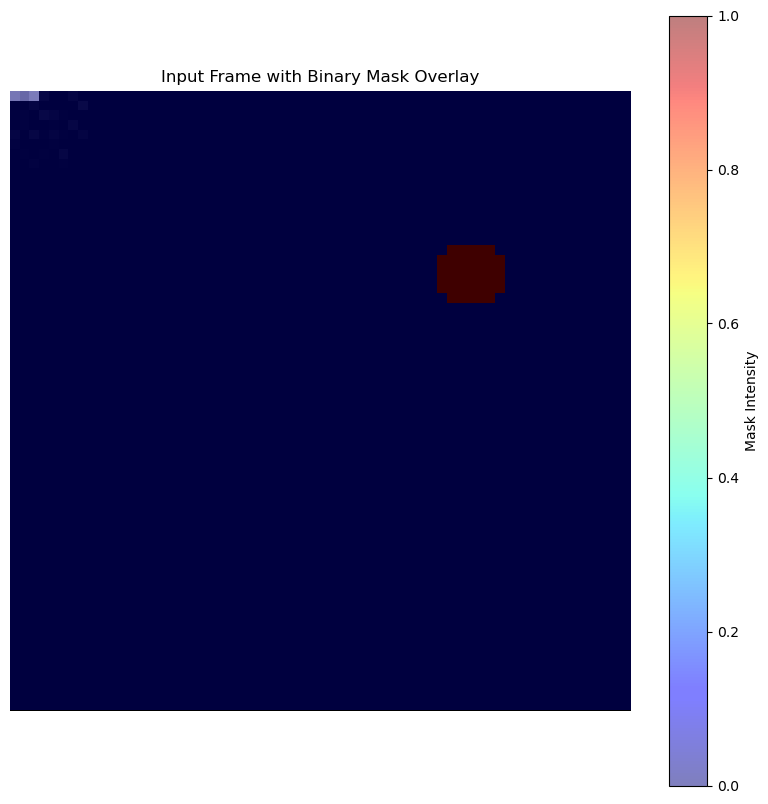

In [2]:
# GENERATE MASKS

import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

def generate_binary_mask(kp_heatmap, threshold=0.5):
    """
    Generate a binary mask from a heatmap using a threshold.

    Parameters:
        kp_heatmap (np.ndarray): Heatmap for a specific keypoint.
        threshold (float): Threshold value for binary mask creation.

    Returns:
        np.ndarray: Binary mask with values 0 and 1.
    """
    # Normalize the heatmap to [0, 1]
    normalized_heatmap = kp_heatmap / kp_heatmap.max()

    # Generate binary mask
    binary_mask = (normalized_heatmap > threshold).astype(float)

    return binary_mask


def visualize_binary_mask(input_frame, binary_mask):
    """
    Visualize the binary mask overlayed on the input frame.

    Parameters:
        input_frame (np.ndarray): Grayscale image frame.
        binary_mask (np.ndarray): Binary mask for overlay.
    """
    plt.figure(figsize=(10, 10))

    # Display the input frame
    plt.imshow(input_frame, cmap="gray", interpolation="nearest")

    # Overlay the binary mask
    plt.imshow(binary_mask, cmap="jet", alpha=0.5, interpolation="nearest")
    plt.colorbar(label="Mask Intensity")
    plt.title("Input Frame with Binary Mask Overlay")
    plt.axis("off")
    plt.show()


# Assuming 'pose_instance' is already set up and the model is loaded
video_file = "/Users/annastuckert/Documents/GitHub/facemap_software/cam1_G7c1_1_10seconds.avi"  # Replace with your video path
pose_instance = Pose(
    filenames=[[video_file]],
    bbox=[],
    bbox_set=False,
    resize=False,
    add_padding=False,
    gui=None,
    GUIobject=None,
    net=None,
    model_name=None,
)

# Run pose prediction setup
pose_instance.pose_prediction_setup()

# Predict landmarks and heatmaps
video_id = 0
pred_data, metadata = pose_instance.predict_landmarks(video_id=video_id)
heatmaps = pose_instance.heatmaps  # Access heatmaps from the object

# Example Usage
# Extract a heatmap for a specific key point and frame
frame_index = 100  # Adjust as needed
keypoint_index = 0  # First keypoint
kp_heatmap = heatmaps[frame_index][keypoint_index].cpu().numpy()

# Normalize and threshold to generate a binary mask
threshold = 0.5
binary_mask = generate_binary_mask(kp_heatmap, threshold=threshold)

# Open the video and extract the frame for visualization
cap = cv2.VideoCapture(video_file)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
ret, frame = cap.read()
cap.release()

if not ret:
    raise ValueError(f"Could not read frame {frame_index} from {video_file}")

# Convert the frame to grayscale
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Visualize the binary mask overlayed on the input frame
visualize_binary_mask(frame_gray, binary_mask)
